In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import struct
import socket
import sys
import subprocess
from ast import literal_eval
from time import time
from datetime import timedelta
from math import sqrt, log
import json

In [2]:
result = pd.read_csv(r"D:/Kanav/College/Thapar BE CSE/6th Sem/Capstone Project/Datasets/ISCX_dataset/Combined_ISCX.csv")
result

C:\Users\Kanav Chauhan\AppData\Local\Temp\ipykernel_15300\2631312641.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  result =pd.read_csv(r"D:/Kanav/College/Thapar BE CSE/6th Sem/Capstone Project/Datasets/ISCX_dataset/Combined_ISCX.csv")


,Unnamed: 0,generated,appName,totalSourceBytes,totalDestinationBytes,totalDestinationPackets,totalSourcePackets,sourcePayloadAsBase64,sourcePayloadAsUTF,destinationPayloadAsBase64,...,sourceTCPFlagsDescription,destinationTCPFlagsDescription,source,protocolName,sourcePort,destination,destinationPort,startDateTime,stopDateTime,Label
0,0,3/11/2014 18:21,Unknown_UDP,16076,0,0,178,NaN,NaN,NaN,...,NaN,NaN,192.168.5.122,udp_ip,5353,224.0.0.251,5353,6/13/2010 23:57,6/14/2010 0:11,Normal
1,1,3/11/2014 18:21,HTTPImageTransfer,384,0,0,6,NaN,NaN,NaN,...,"F,A",NaN,192.168.2.111,tcp_ip,4435,206.217.198.186,80,6/13/2010 23:58,6/14/2010 0:01,Normal
2,2,3/11/2014 18:21,DNS,171,642,4,2,NaN,NaN,NaN,...,NaN,NaN,192.168.4.119,udp_ip,4428,192.168.5.122,53,6/13/2010 23:58,6/13/2010 23:59,Normal
3,3,3/11/2014 18:21,HTTPImageTransfer,384,0,0,6,NaN,NaN,NaN,...,"F,A",NaN,192.168.4.119,tcp_ip,3639,219.94.203.105,80,6/13/2010 23:58,6/14/2010 0:00,Normal
4,4,3/11/2014 18:21,HTTPImageTransfer,186,128,2,2,NaN,NaN,NaN,...,"F,P,A",R,192.168.4.119,tcp_ip,3641,98.137.80.50,80,6/13/2010 23:58,6/13/2010 23:59,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071652,522258,3/11/2014 17:12,HTTPWeb,424,6264,6,6,R0VUIC9mYXEuaHRtbCBIVFRQLzEuMQ0KSG9zdDogc21hcn...,GET /faq.html HTTP/1.1Host: smart-c.jp,SFRUUC8xLjEgMjAwIE9LDQpEYXRlOiBUaHUsIDE3IEp1bi...,...,"S,P,A","S,P,A",192.168.2.107,tcp_ip,3469,125.6.164.51,80,6/16/2010 23:58,6/16/2010 23:58,Normal
2071653,522259,3/11/2014 17:12,HTTPWeb,495,3164,5,6,NaN,NaN,NaN,...,"F,S,P,A","F,S,P,A",192.168.1.105,tcp_ip,37221,203.73.24.75,80,6/16/2010 23:58,6/16/2010 23:58,Normal
2071654,522260,3/11/2014 17:12,DNS,91,288,1,1,54cBAAABAAAAAAABBGJsb2cHdHdpdHRlcgNjb20AAAEAAQ...,......blog.twitter.com..)..,54eBgAABAAMABAAFBGJsb2cHdHdpdHRlcgNjb20AAAEAAc...,...,NaN,NaN,192.168.5.122,udp_ip,24145,198.164.30.2,53,6/16/2010 23:58,6/16/2010 23:58,Normal
2071655,522261,3/11/2014 17:12,DNS,91,243,1,1,LnYBAAABAAAAAAABA2docwFsBmdvb2dsZQNjb20AAAEAAQ...,.v....ghs.l.google.com..)..,LnaBgAABAAEABAAFA2docwFsBmdvb2dsZQNjb20AAAEAAc...,...,NaN,NaN,192.168.5.122,udp_ip,10960,198.164.30.2,53,6/16/2010 23:58,6/16/2010 23:58,Normal


In [17]:
# Compute average packet size with zero division handling
result['avgPacketSizeSource'] = np.where(
    result['totalSourcePackets'] == 0, 
    0, 
    result['totalSourceBytes'] / result['totalSourcePackets']
)

result['avgPacketSizeDestination'] = np.where(
    result['totalDestinationPackets'] == 0, 
    0, 
    result['totalDestinationBytes'] / result['totalDestinationPackets']
)

In [13]:
# Convert timestamps to datetime
result['startDateTimeConverted'] = pd.to_datetime(result['startDateTime'])
result['stopDateTimeConverted'] = pd.to_datetime(result['stopDateTime'])

In [15]:
# Calculate inter-arrival time for flows
result['interArrivalTime'] = (result['stopDateTimeConverted'] - result['startDateTimeConverted']).dt.total_seconds()

In [ ]:
print(result[['avgPacketSizeSource', 'avgPacketSizeDestination', 'interArrivalTime']])

In [23]:
# Extract only packet size and inter arrival time features
new_features = ['avgPacketSizeSource', 'avgPacketSizeDestination', 'interArrivalTime']
new_df = result[new_features]
new_df

,avgPacketSizeSource,avgPacketSizeDestination,interArrivalTime
0,90.314607,0.0,840.0
1,64.000000,0.0,180.0
2,85.500000,160.5,60.0
3,64.000000,0.0,120.0
4,93.000000,64.0,60.0
...,...,...,...
2071652,70.666667,1044.0,0.0
2071653,82.500000,632.8,0.0
2071654,91.000000,288.0,0.0
2071655,91.000000,243.0,0.0


In [26]:
attack_dict = {"Normal": 0, "Attack": 1}
result["EncodedLabel"] = result["Label"].apply(
    lambda x: attack_dict[x]
)

In [27]:
result["EncodedLabel"].unique()

array([0, 1], dtype=int64)

In [28]:
X = new_df
y = result['EncodedLabel'].astype(int)

result.drop(axis=1, columns=["sourcePayloadAsBase64", "sourcePayloadAsUTF",
                                "destinationPayloadAsBase64", "destinationPayloadAsUTF"], inplace=True)
result.drop(axis=1, columns='generated', inplace=True)
result["source"] = result["source"].apply(
    lambda ip: struct.unpack("!I", socket.inet_aton(ip))[0]
)
result["destination"] = result["destination"].apply(
    lambda ip: struct.unpack("!I", socket.inet_aton(ip))[0]
)
def process_time(time):
    time = time.split(" ")[-1]
    h, m = time.split(":")
    return 3600*int(h)+60*int(m)


result["startDateTime"] = result["startDateTime"].apply(
    lambda time: process_time(time)
)

result["stopDateTime"] = result["stopDateTime"].apply(
    lambda time: process_time(time)
)
def flags_transform(flags):
    value = 0
    if type(flags) is str:
        flags = flags.replace(" ", "")
        for c in flags:
            if c != ',':
                value += ord(c)
    return value


result["sourceTCPFlagsDescription"] = result["sourceTCPFlagsDescription"].apply(
    lambda flags: flags_transform(flags)
)

result["destinationTCPFlagsDescription"] = result["destinationTCPFlagsDescription"].apply(
    lambda flags: flags_transform(flags)
)
result["protocolName"] = result["protocolName"].astype("category")
result["protocolName"] = result["protocolName"].cat.codes
result["appName"] = result["appName"].astype("category")
result["appName"] = result["appName"].cat.codes
result["direction"] = result["direction"].astype("category")
result["direction"] = result["direction"].cat.codes
attack_dict = {"Normal": 0, "Attack": 1}
result["Label"] = result["Label"].apply(
    lambda x: attack_dict[x]
)
result= result.fillna(0)

X=result.drop('Label',axis=1)
y=result['Label']

X.columns

X=X.drop('Unnamed: 0',axis=1)


from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(X.to_numpy())
df0 = pd.DataFrame(df_scaled, columns=['appName', 'totalSourceBytes', 'totalDestinationBytes',
       'totalDestinationPackets', 'totalSourcePackets', 'direction',
       'sourceTCPFlagsDescription', 'destinationTCPFlagsDescription', 'source',
       'protocolName', 'sourcePort', 'destination', 'destinationPort',
       'startDateTime', 'stopDateTime'])

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(df0,y , 
                                   random_state=104,  
                                   test_size=0.1,  
                                   shuffle=True) 

In [30]:
from sklearn.preprocessing import StandardScaler

# Convert all non-numeric values to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values (if desired)
X = X.dropna()

# Initialize StandardScaler
scaler = StandardScaler()

# Standard scale the features in X
X_scaled = scaler.fit_transform(X)

# Convert the scaled features back into a DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

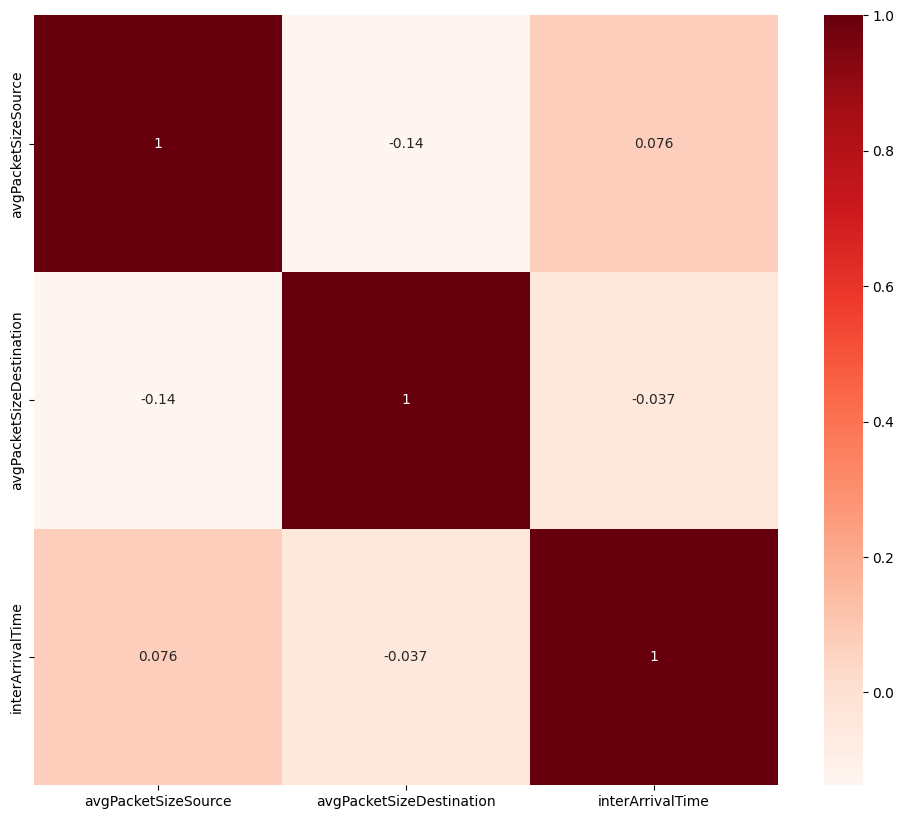

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,10))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# RNN

In [33]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense,Dropout

In [34]:
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(None, 1)))
model.add(Dense(units=64))
model.add(Dropout(0.3))
model.add(Dense(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

%time history_RNN = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)

predictions = model.predict(X_test)



Epoch 1/50


12948/12948 [==============================] - 93s 7ms/step - loss: 0.0697 - accuracy: 0.9765 - val_loss: 0.0630 - val_accuracy: 0.9776
Epoch 2/50
12948/12948 [==============================] - 92s 7ms/step - loss: 0.0601 - accuracy: 0.9784 - val_loss: 0.0576 - val_accuracy: 0.9794
Epoch 3/50
12948/12948 [==============================] - 92s 7ms/step - loss: 0.0575 - accuracy: 0.9792 - val_loss: 0.0562 - val_accuracy: 0.9783
Epoch 4/50
12948/12948 [==============================] - 91s 7ms/step - loss: 0.0560 - accuracy: 0.9798 - val_loss: 0.0544 - val_accuracy: 0.9803
Epoch 5/50
12948/12948 [==============================] - 91s 7ms/step - loss: 0.0548 - accuracy: 0.9803 - val_loss: 0.0544 - val_accuracy: 0.9805
Epoch 6/50
12948/12948 [==============================] - 92s 7ms/step - loss: 0.0537 - accuracy: 0.9806 - val_loss: 0.0526 - val_accuracy: 0.9803
Epoch 7/50
12948/12948 [==============================] - 92s 7ms/step - loss: 0.0522 - accuracy: 0.9811 - val_los

12948/12948 [==============================] - 85s 7ms/step - loss: 0.0448 - accuracy: 0.9831 - val_loss: 0.0442 - val_accuracy: 0.9834
CPU times: total: 9min 9s
Wall time: 1h 14min 16s
12948/12948 [==============================] - 37s 3ms/step


In [35]:
predictions = (predictions > 0.5).astype(int)

In [36]:
from sklearn.metrics import  accuracy_score
print("accuracy"+" "+str(accuracy_score(y_test, predictions)*100))
from sklearn.metrics import f1_score
f1 = f1_score(y_test,predictions )
print("f1score"+" "+str(f1*100))

accuracy 98.34408155778458
f1score 70.59025247545972


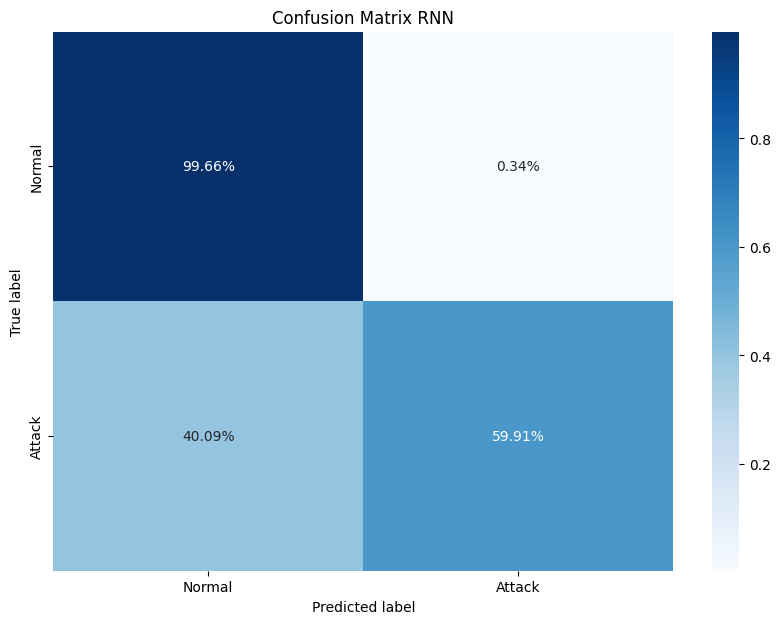

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)

# Normalize the confusion matrix by the number of samples in each true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix RNN')
plt.show()

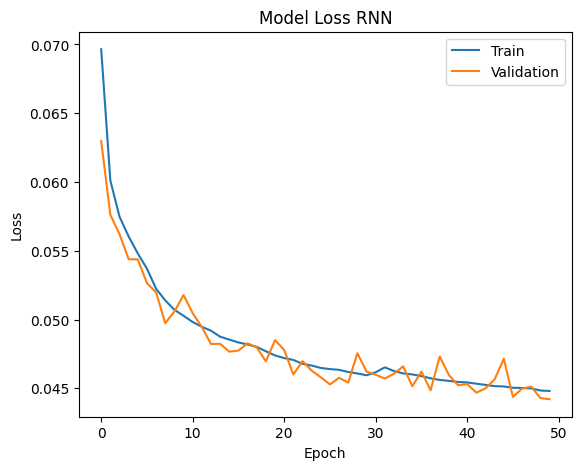

In [38]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])
plt.title('Model Loss RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()


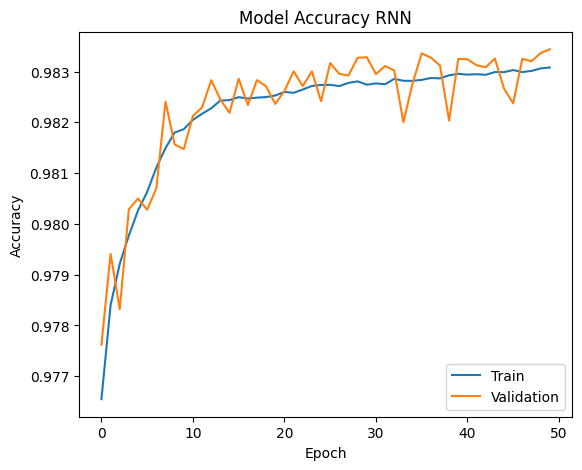

In [39]:

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_RNN.history['accuracy'])
plt.plot(history_RNN.history['val_accuracy'])
plt.title('Model Accuracy RNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

# Attention RNN

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dense, Concatenate, Dot, Activation
import numpy as np

class AttentionRNN(Model):
    def __init__(self, units):
        super(AttentionRNN, self).__init__()
        self.units = units
        self.rnn = SimpleRNN(units, return_sequences=True, return_state=True)
        self.Wc = Dense(units)
        self.Va = Dense(1)

    def call(self, inputs):
        # inputs shape: (batch_size, sequence_length, input_dim)
        
        # RNN output and hidden state calculation
        outputs, state = self.rnn(inputs)
        
        # Expand dimensions of hidden state to perform addition
        hidden_with_time_axis = tf.expand_dims(state, 1)
        
        # Attention score calculation
        score = self.Va(tf.nn.tanh(self.Wc(outputs) + hidden_with_time_axis))
        
        # Attention weights calculation
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # Weighted sum of outputs based on attention weights
        context_vector = attention_weights * outputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector

# Define the model architecture
input_shape = (None, 1)
units = 32
inputs = Input(shape=input_shape)
rnn_layer = AttentionRNN(units)
outputs = rnn_layer(inputs)

# Define output layer
outputs = Dense(1, activation='sigmoid')(outputs)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
%time history_RNN_att = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test))


Epoch 1/50
3237/3237 [==============================] - 39s 11ms/step - loss: 0.0819 - accuracy: 0.9731 - val_loss: 0.0614 - val_accuracy: 0.9791
Epoch 2/50
3237/3237 [==============================] - 34s 11ms/step - loss: 0.0578 - accuracy: 0.9794 - val_loss: 0.0565 - val_accuracy: 0.9801
Epoch 3/50
3237/3237 [==============================] - 34s 10ms/step - loss: 0.0557 - accuracy: 0.9799 - val_loss: 0.0557 - val_accuracy: 0.9804
Epoch 4/50
3237/3237 [==============================] - 34s 11ms/step - loss: 0.0547 - accuracy: 0.9803 - val_loss: 0.0543 - val_accuracy: 0.9810
Epoch 5/50
3237/3237 [==============================] - 35s 11ms/step - loss: 0.0534 - accuracy: 0.9806 - val_loss: 0.0540 - val_accuracy: 0.9798
Epoch 6/50
3237/3237 [==============================] - 35s 11ms/step - loss: 0.0520 - accuracy: 0.9811 - val_loss: 0.0511 - val_accuracy: 0.9809
Epoch 7/50
3237/3237 [==============================] - 34s 10ms/step - loss: 0.0505 - accuracy: 0.9815 - val_loss: 0.0495 -

In [41]:
loss, accuracy = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
from sklearn.metrics import  accuracy_score
print("accuracy"+" "+str(accuracy_score(y_test, predictions)*100))
from sklearn.metrics import f1_score
f1 = f1_score(y_test,predictions )
print("f1score"+" "+str(f1*100))

12948/12948 [==============================] - 56s 4ms/step
accuracy 98.37280248689457
f1score 71.814381270903


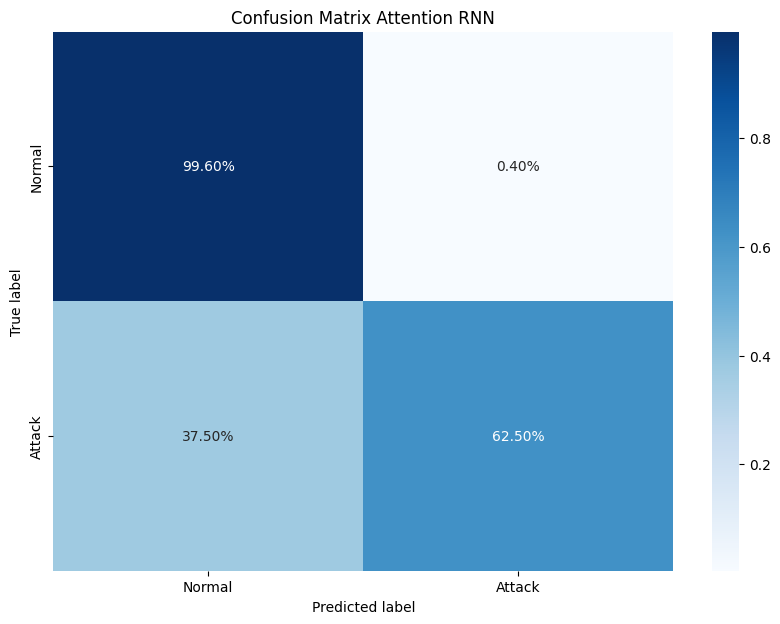

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)

# Normalize the confusion matrix by the number of samples in each true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Attention RNN')
plt.show()

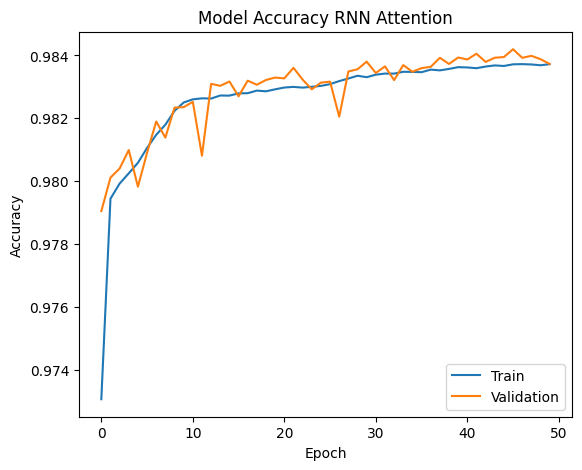

In [43]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_RNN_att.history['accuracy'])
plt.plot(history_RNN_att.history['val_accuracy'])
plt.title('Model Accuracy RNN Attention')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

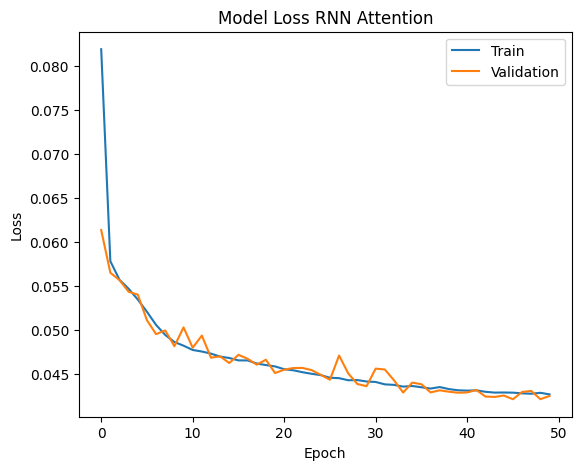

In [44]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history_RNN_att.history['loss'])
plt.plot(history_RNN_att.history['val_loss'])
plt.title('Model Loss RNN Attention')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()


# LSTM

In [45]:
# Import necessary libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import numpy as np

# Define the model architecture
model = Sequential()
model.add(LSTM(units=16, input_shape=(None, 1)))
model.add(Dense(units=32))
model.add(Dense(units=64))
model.add(Dropout(0.4))
model.add(Dense(units=32))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
%time history_LSTM = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

# Make predictions using the model
predictions = model.predict(X_test)


Epoch 1/50
12948/12948 [==============================] - 113s 8ms/step - loss: 0.0787 - accuracy: 0.9725 - val_loss: 0.0636 - val_accuracy: 0.9767
Epoch 2/50
12948/12948 [==============================] - 108s 8ms/step - loss: 0.0606 - accuracy: 0.9781 - val_loss: 0.0595 - val_accuracy: 0.9779
Epoch 3/50
12948/12948 [==============================] - 106s 8ms/step - loss: 0.0586 - accuracy: 0.9787 - val_loss: 0.0588 - val_accuracy: 0.9797
Epoch 4/50
12948/12948 [==============================] - 104s 8ms/step - loss: 0.0576 - accuracy: 0.9792 - val_loss: 0.0580 - val_accuracy: 0.9805
Epoch 5/50
12948/12948 [==============================] - 102s 8ms/step - loss: 0.0564 - accuracy: 0.9799 - val_loss: 0.0562 - val_accuracy: 0.9806
Epoch 6/50
12948/12948 [==============================] - 111s 9ms/step - loss: 0.0550 - accuracy: 0.9806 - val_loss: 0.0542 - val_accuracy: 0.9813
Epoch 7/50
12948/12948 [==============================] - 110s 8ms/step - loss: 0.0540 - accuracy: 0.9810 - val_

In [46]:
predictions = (predictions > 0.5).astype(int)
from sklearn.metrics import  accuracy_score
print("accuracy"+" "+str(accuracy_score(y_test, predictions)*100))
from sklearn.metrics import f1_score
f1 = f1_score(y_test,predictions )
print("f1score"+" "+str(f1*100))

accuracy 98.38004305725843
f1score 71.77697418215458


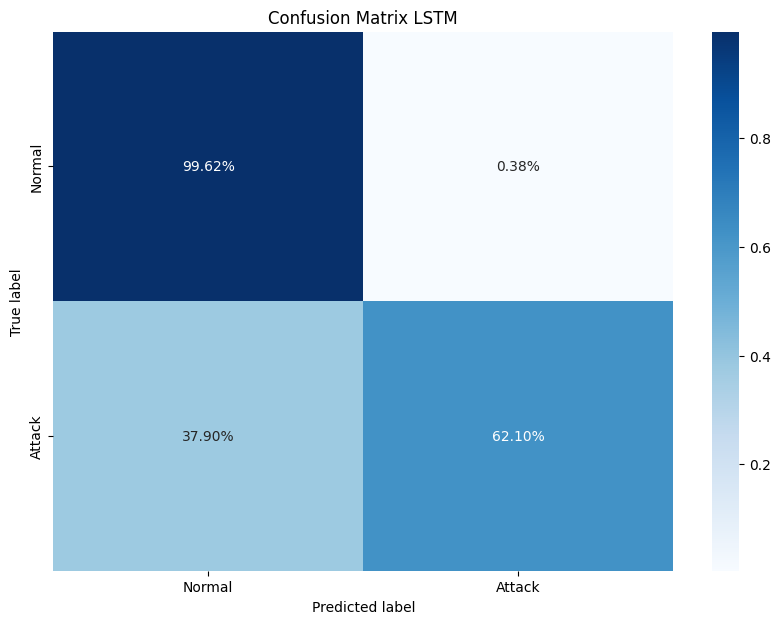

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)

# Normalize the confusion matrix by the number of samples in each true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix LSTM')
plt.show()


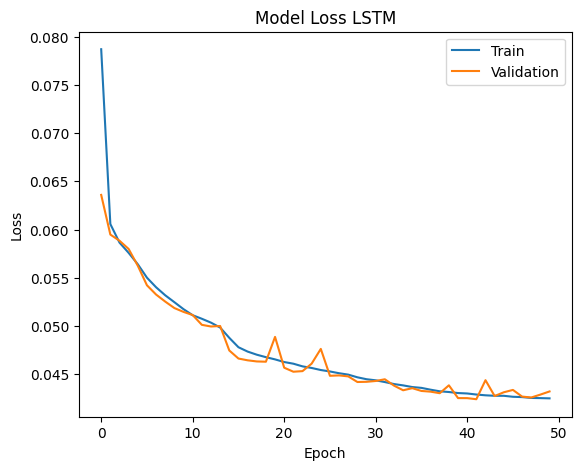

In [48]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('Model Loss LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()


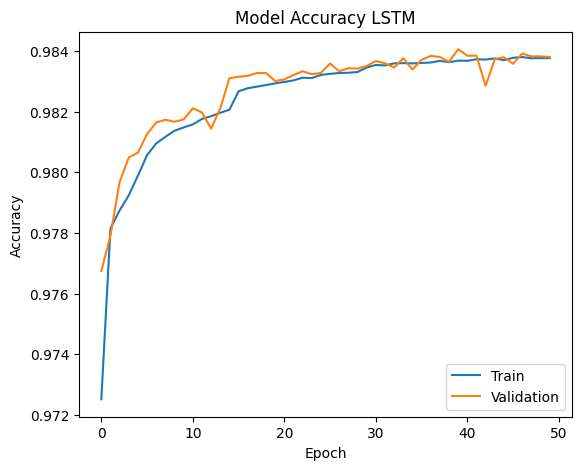

In [49]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.title('Model Accuracy LSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

# Attention LSTM

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dot, Activation
import numpy as np

class AttentionLSTM(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AttentionLSTM, self).__init__()
        self.units = units
        self.rnn = LSTM(units, return_sequences=True, return_state=True)
        self.Wc = Dense(units)
        self.Va = Dense(1)

    def call(self, inputs, training=None):
        # inputs shape: (batch_size, sequence_length, input_dim)
        
        # RNN output and hidden state calculation
        outputs, state_h, state_c = self.rnn(inputs)
        
        # Expand dimensions of hidden state to perform addition
        hidden_with_time_axis = tf.expand_dims(state_h, 1)
        
        # Attention score calculation
        score = self.Va(tf.nn.tanh(self.Wc(outputs) + hidden_with_time_axis))
        
        # Attention weights calculation
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # Weighted sum of outputs based on attention weights
        context_vector = attention_weights * outputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector

# Define the model architecture
input_shape = (None, 1)
units = 32
inputs = Input(shape=input_shape)
attention_lstm_layer = AttentionLSTM(units)
context_vector = attention_lstm_layer(inputs)

# Define output layer
outputs = Dense(1, activation='sigmoid')(context_vector)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Assuming X_train and y_train are predefined
# X_train shape should be (num_samples, sequence_length, input_dim)
# y_train shape should be (num_samples,)

# Train the model
%time history_LSTM_att = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test))


Epoch 1/50
3237/3237 [==============================] - 69s 19ms/step - loss: 0.1009 - accuracy: 0.9700 - val_loss: 0.0747 - val_accuracy: 0.9737
Epoch 2/50
3237/3237 [==============================] - 57s 17ms/step - loss: 0.0657 - accuracy: 0.9757 - val_loss: 0.0592 - val_accuracy: 0.9805
Epoch 3/50
3237/3237 [==============================] - 57s 17ms/step - loss: 0.0568 - accuracy: 0.9807 - val_loss: 0.0557 - val_accuracy: 0.9807
Epoch 4/50
3237/3237 [==============================] - 58s 18ms/step - loss: 0.0542 - accuracy: 0.9811 - val_loss: 0.0541 - val_accuracy: 0.9815
Epoch 5/50
3237/3237 [==============================] - 56s 17ms/step - loss: 0.0534 - accuracy: 0.9814 - val_loss: 0.0543 - val_accuracy: 0.9810
Epoch 6/50
3237/3237 [==============================] - 57s 18ms/step - loss: 0.0530 - accuracy: 0.9815 - val_loss: 0.0539 - val_accuracy: 0.9811
Epoch 7/50
3237/3237 [==============================] - 57s 18ms/step - loss: 0.0526 - accuracy: 0.9816 - val_loss: 0.0527 -

In [51]:
loss, accuracy = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
from sklearn.metrics import  accuracy_score
print("accuracy"+" "+str(accuracy_score(y_test, predictions)*100))
from sklearn.metrics import f1_score
f1 = f1_score(y_test,predictions )
print("f1score"+" "+str(f1*100))

12948/12948 [==============================] - 64s 5ms/step
accuracy 98.3356342256934
f1score 70.31169278457034


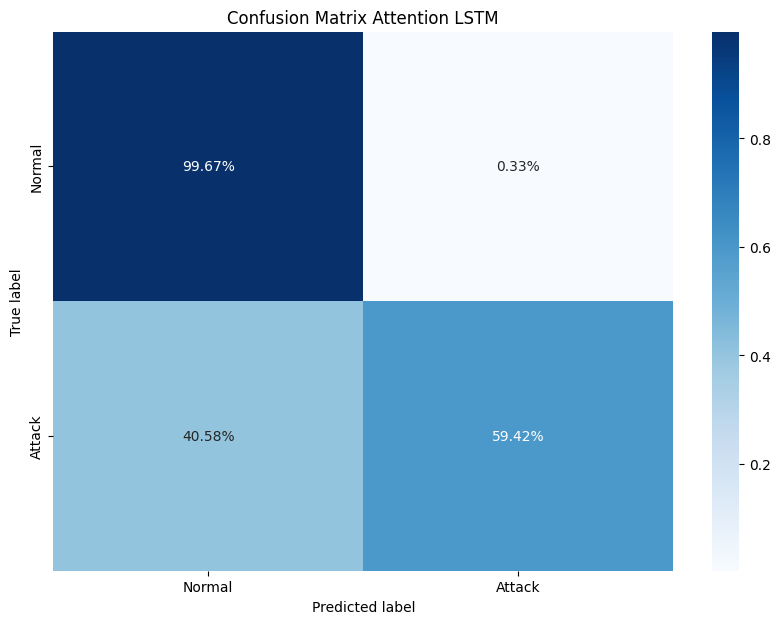

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)

# Normalize the confusion matrix by the number of samples in each true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Attention LSTM')
plt.show()

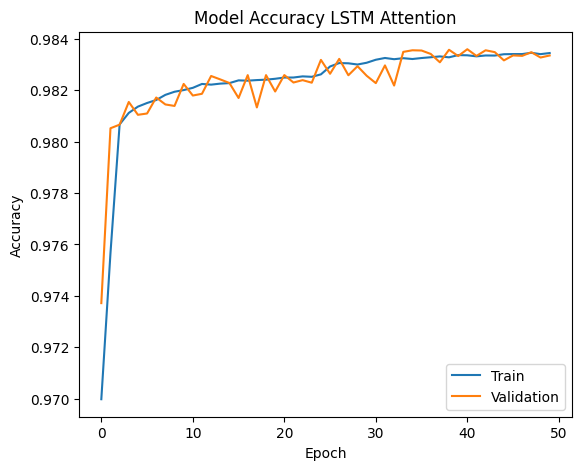

In [53]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_LSTM_att.history['accuracy'])
plt.plot(history_LSTM_att.history['val_accuracy'])
plt.title('Model Accuracy LSTM Attention')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

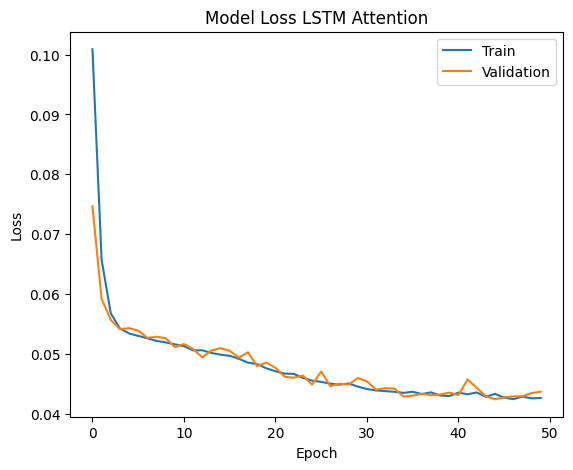

In [54]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history_LSTM_att.history['loss'])
plt.plot(history_LSTM_att.history['val_loss'])
plt.title('Model Loss LSTM Attention')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()


# GRU

In [55]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
# Define the model architecture
model = Sequential()
model.add(GRU(units=32, input_shape=(None, 1)))
model.add(Dense(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model with early stopping
# %time history_GRU = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

%time history_GRU = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
# Make predictions using the model
predictions = model.predict(X_test)

Epoch 1/50
12948/12948 [==============================] - 124s 9ms/step - loss: 0.0673 - accuracy: 0.9770 - val_loss: 0.0576 - val_accuracy: 0.9791
Epoch 2/50
12948/12948 [==============================] - 118s 9ms/step - loss: 0.0567 - accuracy: 0.9799 - val_loss: 0.0546 - val_accuracy: 0.9811
Epoch 3/50
12948/12948 [==============================] - 119s 9ms/step - loss: 0.0544 - accuracy: 0.9809 - val_loss: 0.0530 - val_accuracy: 0.9814
Epoch 4/50
12948/12948 [==============================] - 121s 9ms/step - loss: 0.0529 - accuracy: 0.9812 - val_loss: 0.0526 - val_accuracy: 0.9817
Epoch 5/50
12948/12948 [==============================] - 118s 9ms/step - loss: 0.0519 - accuracy: 0.9816 - val_loss: 0.0507 - val_accuracy: 0.9814
Epoch 6/50
12948/12948 [==============================] - 121s 9ms/step - loss: 0.0509 - accuracy: 0.9818 - val_loss: 0.0496 - val_accuracy: 0.9822
Epoch 7/50
12948/12948 [==============================] - 127s 10ms/step - loss: 0.0493 - accuracy: 0.9822 - val

In [56]:

predictions = (predictions > 0.5).astype(int)
from sklearn.metrics import  accuracy_score
print("accuracy"+" "+str(accuracy_score(y_test, predictions)*100))
from sklearn.metrics import f1_score
f1 = f1_score(y_test,predictions )
print("f1score"+" "+str(f1*100))

accuracy 98.31077493411081
f1score 69.82539340375081


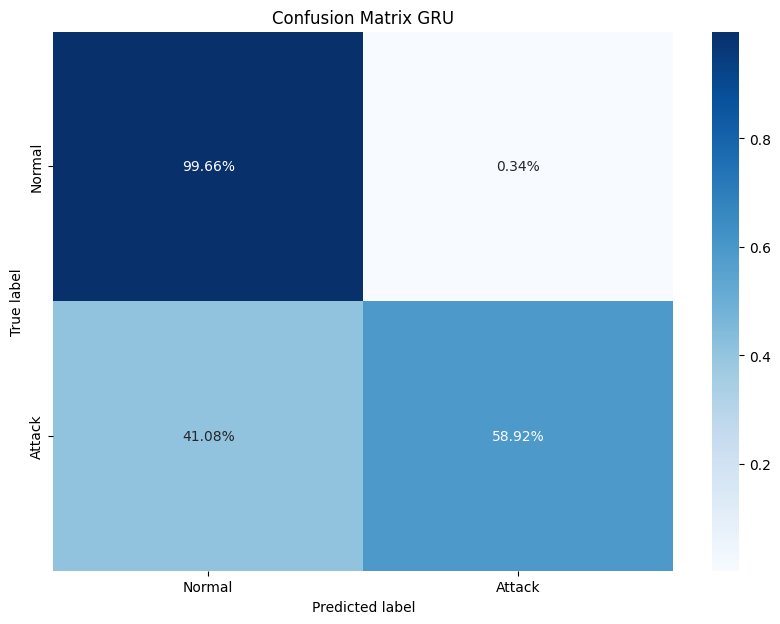

In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)

# Normalize the confusion matrix by the number of samples in each true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix GRU')
plt.show()

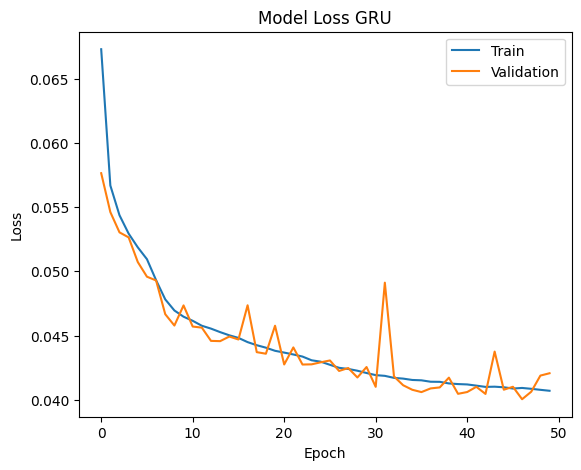

In [58]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.title('Model Loss GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()


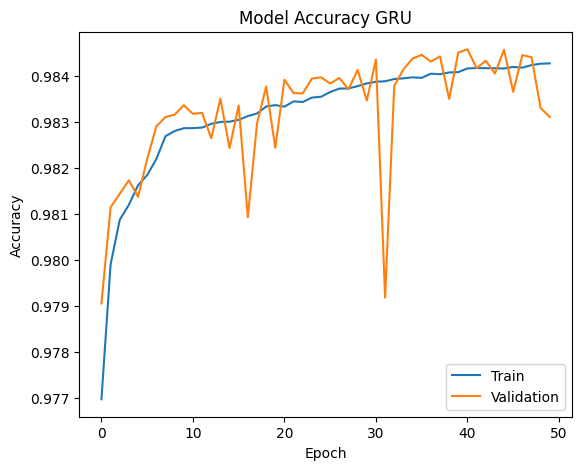

In [59]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_GRU.history['accuracy'])
plt.plot(history_GRU.history['val_accuracy'])
plt.title('Model Accuracy GRU')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

# Attention GRU

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, Dot, Activation
import numpy as np

class AttentionGRU(Model):
    def __init__(self, units):
        super(AttentionGRU, self).__init__()
        self.units = units
        self.gru = GRU(units, return_sequences=True, return_state=True)
        self.Wc = Dense(units)
        self.Va = Dense(1)

    def call(self, inputs):
        # inputs shape: (batch_size, sequence_length, input_dim)
        
        # GRU output and hidden state calculation
        outputs, state = self.gru(inputs)
        
        # Expand dimensions of hidden state to perform addition
        hidden_with_time_axis = tf.expand_dims(state, 1)
        
        # Attention score calculation
        score = self.Va(tf.nn.tanh(self.Wc(outputs) + hidden_with_time_axis))
        
        # Attention weights calculation
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # Weighted sum of outputs based on attention weights
        context_vector = attention_weights * outputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector

# Define the model architecture
input_shape = (None, 1)
units = 32
inputs = Input(shape=input_shape)
gru_layer = AttentionGRU(units)
outputs = gru_layer(inputs)

# Define output layer
outputs = Dense(1, activation='sigmoid')(outputs)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
%time history_GRU_att = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

Epoch 1/50
3237/3237 [==============================] - 56s 15ms/step - loss: 0.0877 - accuracy: 0.9738 - val_loss: 0.0617 - val_accuracy: 0.9785
Epoch 2/50
3237/3237 [==============================] - 47s 15ms/step - loss: 0.0594 - accuracy: 0.9798 - val_loss: 0.0577 - val_accuracy: 0.9811
Epoch 3/50
3237/3237 [==============================] - 47s 14ms/step - loss: 0.0567 - accuracy: 0.9812 - val_loss: 0.0560 - val_accuracy: 0.9816
Epoch 4/50
3237/3237 [==============================] - 46s 14ms/step - loss: 0.0549 - accuracy: 0.9818 - val_loss: 0.0545 - val_accuracy: 0.9821
Epoch 5/50
3237/3237 [==============================] - 46s 14ms/step - loss: 0.0534 - accuracy: 0.9820 - val_loss: 0.0527 - val_accuracy: 0.9826
Epoch 6/50
3237/3237 [==============================] - 46s 14ms/step - loss: 0.0524 - accuracy: 0.9822 - val_loss: 0.0522 - val_accuracy: 0.9825
Epoch 7/50
3237/3237 [==============================] - 47s 14ms/step - loss: 0.0516 - accuracy: 0.9823 - val_loss: 0.0516 -

In [61]:
predictions = (predictions > 0.5).astype(int)
from sklearn.metrics import  accuracy_score
print("accuracy"+" "+str(accuracy_score(y_test, predictions)*100))
from sklearn.metrics import f1_score
f1 = f1_score(y_test,predictions )
print("f1score"+" "+str(f1*100))

accuracy 98.36652732591256
f1score 71.22448979591837


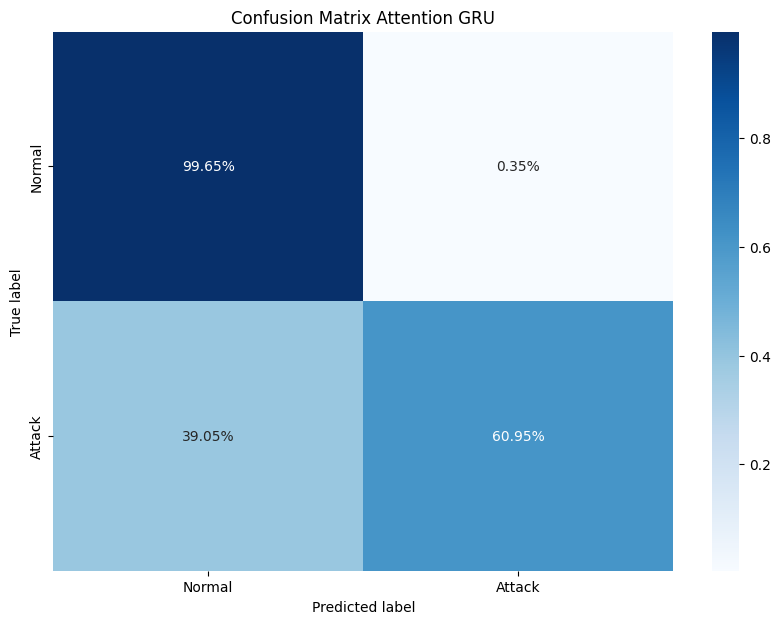

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)

# Normalize the confusion matrix by the number of samples in each true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Attention GRU')
plt.show()


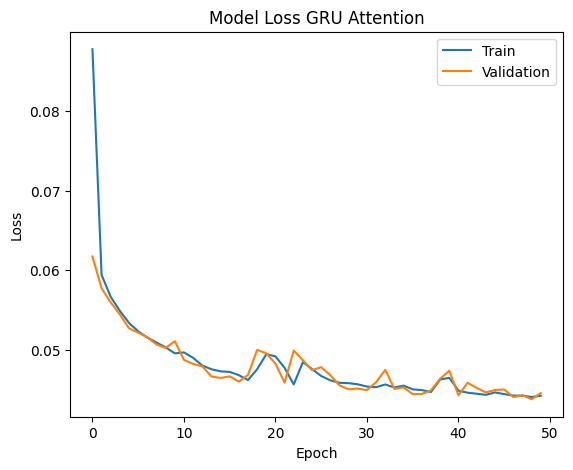

In [63]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history_GRU_att.history['loss'])
plt.plot(history_GRU_att.history['val_loss'])
plt.title('Model Loss GRU Attention')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()


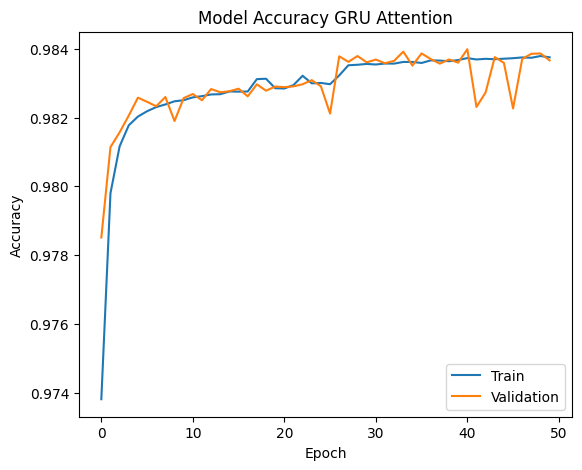

In [64]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_GRU_att.history['accuracy'])
plt.plot(history_GRU_att.history['val_accuracy'])
plt.title('Model Accuracy GRU Attention')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

In [2]:
from PIL import Image
import os

# Path to the folder containing the images
folder_path = r"C:\Users\shiya\Desktop\Learning\Capstone\Iscx Attention Models\ConfusionMatrix"

# Get a list of all image file names in the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Sort the image files (optional)
image_files.sort()

# Load the images
images = [Image.open(os.path.join(folder_path, img)) for img in image_files]

# Determine the size of each image (assuming all images are the same size)
img_width, img_height = images[0].size

# Calculate the size of the final combined image
rows = 3
cols = 2
combined_width = cols * img_width
combined_height = rows * img_height

# Create a new blank image with the calculated size
combined_image = Image.new('RGB', (combined_width, combined_height))

# Paste each image into the combined image
for i, img in enumerate(images):
    x = (i % cols) * img_width
    y = (i // cols) * img_height
    combined_image.paste(img, (x, y))

# Save the combined image
combined_image.save(os.path.join(folder_path, 'combined_image.jpg'))
combined_image.show()
